<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/APTOS_EYEPACS_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move
from google.colab import drive

import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
drive.mount('/gdrive')

In [ ]:
class KaggleJSONFile:
  def __init__(self, folder_path:str):
    self.__folder_location = folder_path
    self.__filename = 'kaggle.json'
    self.__destination_path = '/root/.kaggle'

  def setup(self):
    p_orig = os.path.join(self.__folder_location, self.__filename)
    p_dest = os.path.join(self.__destination_path, self.__filename)

    os.mkdir(self.__destination_path)
    copy(p_orig, p_dest)

    !chmod 600 {p_dest}


In [ ]:
k = KaggleJSONFile('/gdrive/MyDrive/Kaggle_keys')
k.setup()

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

In [ ]:
zipfiles = [f for f in os.listdir('/content') if '.zip' in f]

def unpack(filename:str):
  f = os.path.join('/content', filename)

  unpack_archive(
      filename = f,
      extract_dir='/content'
  )

  return os.path.join('/content',filename.split('.')[0])

dataset_dirs = [unpack(z) for z in zipfiles]

In [ ]:
train_csv_files = [f for f in os.listdir('/content') if '.csv' in f and 'train' in f]
dataframes = [pd.read_csv(csv) for csv in train_csv_files]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.jpeg', '.png']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

classes = range(5)
orig_ds = pd.concat(dataframes)
orig_ds.reset_index(inplace=True)
orig_ds.iloc[0,:]

In [ ]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

dfp = orig_ds.pivot_table(
    index='level',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
plt.savefig(img_path)
plt.show()

In [ ]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [ ]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

In [ ]:
path_dict = {p:os.listdir(p)
              for p in ['/content/train_images', '/content/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

In [ ]:
splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    print(datapoint['image'])
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])
    move(orig_path, dest_path)

Using device cuda:0


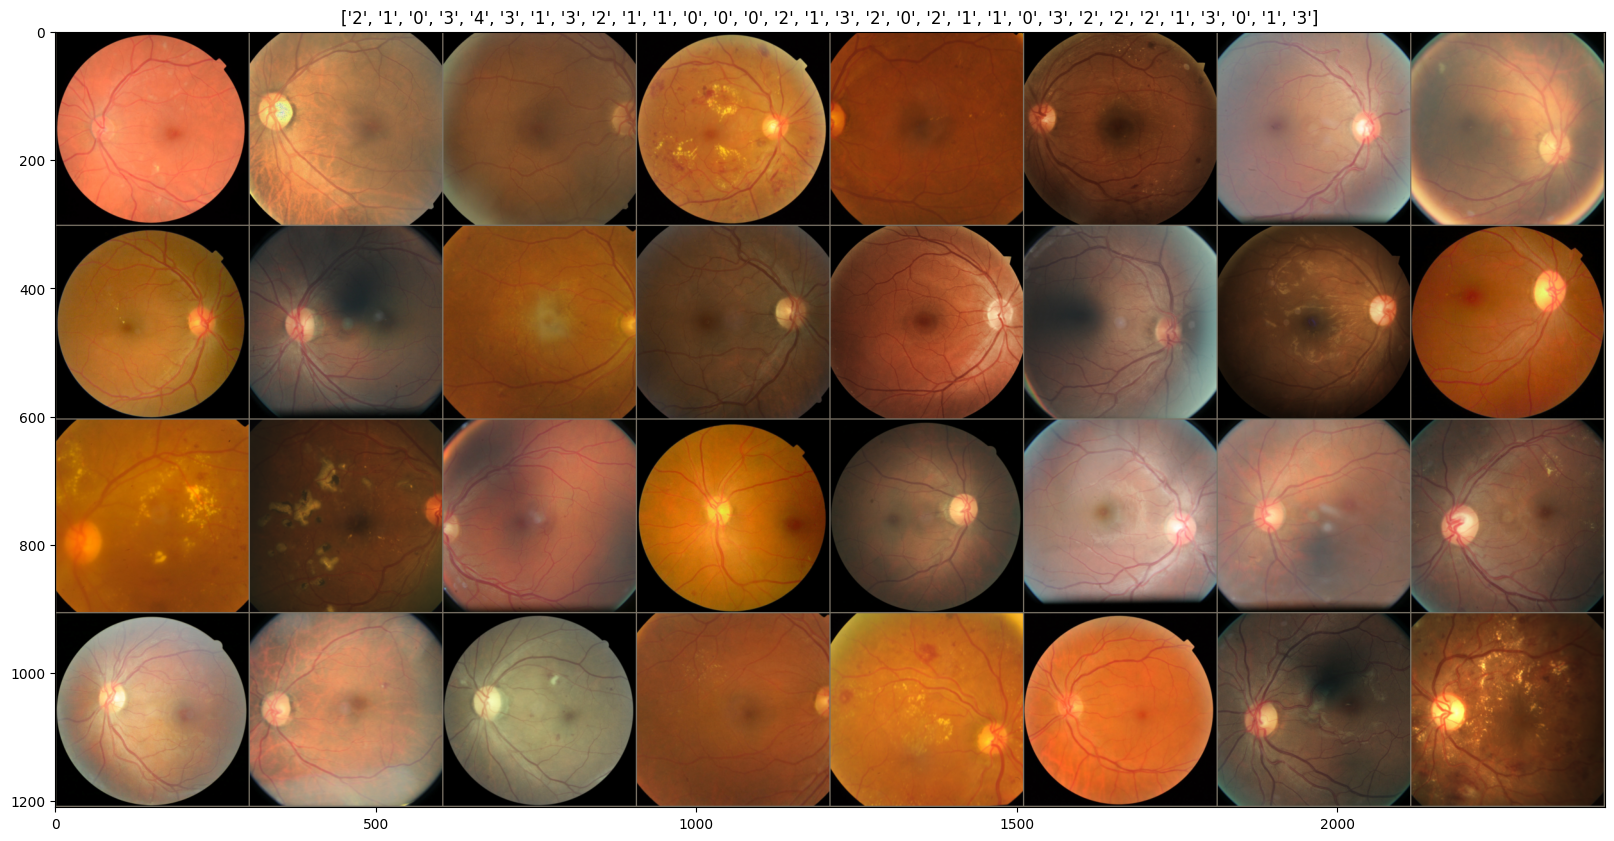

In [78]:
# MobileNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode
## Load Data

IM_SIZE = 300
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=False, num_workers=2)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))
## Training the model


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs+1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model



def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [79]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.MobileNet_V3_Large_Weights.DEFAULT

model_ft = models.mobilenet_v3_large(weights=model_weights)
num_ftrs = model_ft.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
# model_ft.classifier = model_ft.classifier[:-1]
# model_ft.classifier[-1] = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(
#         in_features=num_ftrs,
#         out_features=5,
#         bias=True
#     )
# )
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-5)

# Decay LR by a factor of 0.001 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.001)

display(model_ft)
### Train and evaluate


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
warmup_epochs = 4
training_epochs = warmup_epochs * 5
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')

print(f"Training on device {device}")
for param in model_ft.features.parameters():
    param.requires_grad = False
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=warmup_epochs)

for param in model_ft.features.parameters():
    param.requires_grad = True
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=training_epochs)

MobileNet_V3_Large_Weights.IMAGENET1K_V2_4_20_Grading_17_Apr_23_21_25
Training on device cuda:0
Epoch 1/5
----------
train Loss: 1.3538 Acc: 0.3915
val Loss: 1.4013 Acc: 0.3820
New best model found with validation loss: 1.4013

Epoch 2/5
----------
train Loss: 1.1894 Acc: 0.4845
val Loss: 1.2320 Acc: 0.4300
New best model found with validation loss: 1.2320

Epoch 3/5
----------
train Loss: 1.1228 Acc: 0.5098
val Loss: 1.2302 Acc: 0.4300
New best model found with validation loss: 1.2302

Epoch 4/5
----------
train Loss: 1.0205 Acc: 0.5727
val Loss: 1.2152 Acc: 0.4480
New best model found with validation loss: 1.2152

Training complete in 13m 3s
Best validation loss: 1.2152 | Best validation accuracy: 0.4480
Epoch 1/21
----------
train Loss: 0.9997 Acc: 0.5790
val Loss: 1.2014 Acc: 0.4660
New best model found with validation loss: 1.2014

Epoch 2/21
----------
train Loss: 0.9930 Acc: 0.5850
val Loss: 1.1934 Acc: 0.4720
New best model found with validation loss: 1.1934

Epoch 3/21
-------

In [1]:
if not os.path.exists('models'):
  os.mkdir('models')

MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
torch.save(model_ft.state_dict(), MODEL_PATH)

NameError: ignored

In [ ]:
visualize_model(model_ft)
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

device = torch.device("cpu")
model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

if not os.path.exists('output'):
  os.mkdir('output')
OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)

In [ ]:
import shutil

shutil.copy(MODEL_PATH, '/gdrive/MyDrive/Models')